In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import scipy 
import pdb
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from neurosim.models.ssr import StateSpaceRealization as SSR
import sys

In [2]:
sys.path.append('/home/akumar/nse/neural_control/')

In [3]:
from utils import gram_schmidt

### 

### Tuning Polar Decomposition

In [9]:
def FCCA_score(A):
    P = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))
    # Resolve the contribution of the different terms
    X1 = P @ A.T @ np.linalg.inv(P) @ A
    X2 = A @ P @ A.T @ np.linalg.inv(P)
    X3 = A @ P @ A.T @ A.T @ np.linalg.inv(P) @ A

    # return np.trace(np.eye(A.shape[0]) - P @ A.T @ np.linalg.inv(P) @ A - A @ P @ A.T @ np.linalg.inv(P) + A @ P @ A.T @ A.T @ np.linalg.inv(P) @ A)
    return X1, X2, X3

def LQG_score(A):
    P = scipy.linalg.solve_discrete_are(A, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    Q = scipy.linalg.solve_discrete_are(A.T, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))

    return np.trace(P @ Q)

In [10]:
# Generate A matrices 
dim = 100
nU = 50
nP = 50
seed = 1
# 50 random U matrices. Then modulate the spread of the diagonals of P for each U

U = []
for i in range(nU):
    U.append(ortho_group.rvs(dim))

Puniform = []
for j in range(nP):
    Puniform.append(np.diag(np.linspace(0.775 - j/nP * 0.6, 0.8 + j/nP * 0.6, dim)))
# for i in range(50):

# Check to make sure all eigenvalues have real part < 1
A = [[] for _ in range(nU)]
lambda_max = np.zeros((nU, nP, 2))
for i in range(len(U)):
    for j in range(len(Puniform)):
        A_ = U[i] @ Puniform[j]
        lambda_max[i, j, 0] = np.max(np.abs(np.linalg.eigvals(A_)))     
        A[i].append(A_)

assert(np.all(lambda_max < 1))


In [11]:
from tqdm import tqdm

In [13]:
fcca_scores = np.zeros((nU, nP, 7))
lqg_scores = np.zeros((nU, nP))
normdU = np.zeros((nU, nP))
for i in tqdm(range(nU)):
    for j in range(nP):
        x1, x2, x3 = FCCA_score(A[i][j])
        fcca_scores[i, j, 0] = -1 * np.trace(x1)
        fcca_scores[i, j, 1] = -1 * np.trace(x2)
        fcca_scores[i, j, 2] = np.trace(x3)
        fcca_scores[i, j, 3] = np.trace(np.eye(A[i][j].shape[0])) - np.trace(x1) - np.trace(x2) + np.trace(x3)
        lqg_scores[i, j] = LQG_score(A[i][j])

        U_, P_ = scipy.linalg.polar(A[i][j])
        normdU[i, j] = np.linalg.norm(A[i][j] - U_)/np.linalg.norm(A[i][j])

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
with open('polar_tmp.pkl', 'wb') as f:
    f.write(fcca_scores)
    f.write(lqg_scores)
    f.write(normdU)

NameError: name 'fcca_scores' is not defined

In [33]:
A[0].shape

(100, 100)

In [105]:
fcca_scores.shape

(50, 50, 7)

In [117]:
fcca_scores[:, 0, 3]

array([14.43220271, 14.43215375, 14.43215797, 14.43221317, 14.43223906,
       14.43216137, 14.43217916, 14.43218782, 14.4321919 , 14.43220435,
       14.4322017 , 14.43222693, 14.43223236, 14.432153  , 14.43220583,
       14.43216843, 14.43218179, 14.43221351, 14.43220248, 14.43221099,
       14.43216329, 14.43223342, 14.43217129, 14.43215552, 14.43217882,
       14.43223089, 14.43212445, 14.43218768, 14.43219746, 14.43218031,
       14.43222494, 14.43221217, 14.4322113 , 14.43212842, 14.43220062,
       14.43217956, 14.43219769, 14.43218922, 14.43220119, 14.43227589,
       14.4321932 , 14.43220993, 14.43223901, 14.43214342, 14.4322136 ,
       14.43221162, 14.43222501, 14.43224911, 14.43220507, 14.43222497])

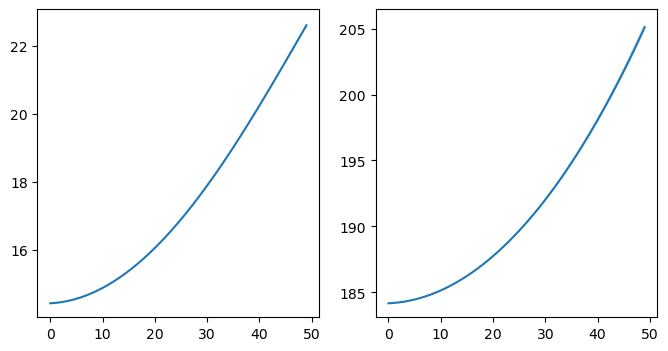

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].fill_between(np.arange(50), np.mean(fcca_scores[..., 3], axis=0) - np.std(fcca_scores[..., 3], axis=0), 
                   np.mean(fcca_scores[..., 3], axis=0) + np.std(fcca_scores[..., 3], axis=0), alpha=0.25)
ax[0].plot(np.mean(fcca_scores[..., 3], axis=0))
ax[1].fill_between(np.arange(50), np.mean(lqg_scores, axis=0) - np.std(lqg_scores, axis=0), 
                   np.mean(lqg_scores, axis=0) + np.std(lqg_scores, axis=0), alpha=0.25)
ax[1].plot(np.mean(lqg_scores, axis=0))


In [37]:
np.allclose(fcca_scores[:, 0], fcca_scores[:, 1])

True

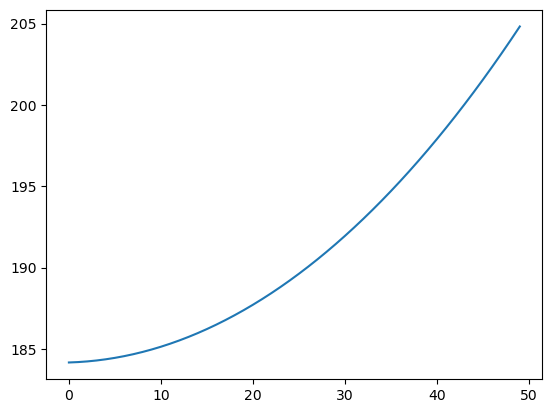

In [28]:
# How dependent is this on the actual objective?
plt.plot(lqg_scores)

In [34]:
# Is it possible to capture analytically the above behavior via an upper bound?

In [ ]:
# Could alternatively think about the LQG singular values. Here, formulas for the trace of the matrix product may be more directly applicable

In [ ]:
# Simplify to a 2x2 system to get more traction

In [94]:
# Check Wolfram Expression
def get_W(th, delta, eps):

    U = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    P = np.diag([1 - eps - delta, 1- eps + delta])
    A = U @ P

    assert(max(np.abs(np.linalg.eigvals(A.T))) < 1)

    W = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))
    return W, A

In [102]:
# Plot of the different 2D dynamics

### 3D -> 2D projections

In [4]:
# In 3D -> 2D, we can use the orientation of the normal vector to define a projection. 
def get_V(theta, phi):
    n = np.array([np.sin(phi) * np.sin(theta), np.cos(phi) * np.sin(theta), np.cos(theta)])
    V = gram_schmidt(n)[:, 1:]
    try:
        assert(np.isclose(scipy.linalg.subspace_angles(V, n[:, np.newaxis]), np.pi/2))
    except:
        pdb.set_trace()
    return n, V

In [5]:
# Plot the normal vector and the plane spanned by the orthogonal directions
from mpl_toolkits.mplot3d import Axes3D

/home/akumar/nse/neural_control/utils.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[:,j] = q/rjj


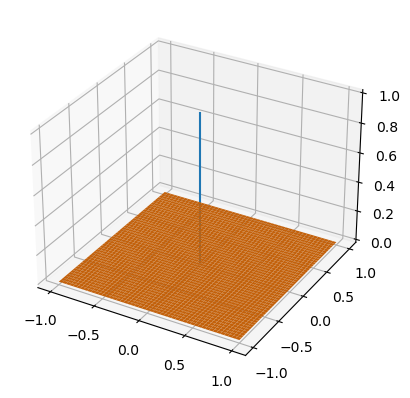

In [133]:
fig = plt.figure()

n, V = get_V(0, 0)

ax = fig.add_subplot(projection='3d')
ax.plot3D([0, n[0]], [0, n[1]], [0, n[2]])

# Plot plane

# create x,y
xx, yy = np.meshgrid(np.linspace(-1, 1), np.linspace(-1, 1))

# calculate corresponding z
z = (-n[0] * xx - n[1] * yy) * 1. /n[2]

# plot the surface
#plt3d = plt.figure().gca(projection='3d')
ax.plot_surface(xx, yy, z)

In [138]:
n

array([0.000000e+00, 1.000000e+00, 6.123234e-17])

In [139]:
V

array([[-0.20136342,  0.81656689],
       [ 0.        ,  0.        ],
       [-0.67974924, -0.43019624]])

In [143]:
%matplotlib inline

In [148]:
fig = plt.figure()

n, V = get_V(np.pi/2, 0)

ax = fig.add_subplot(projection='3d')
ax.plot3D([0, n[0]], [0, n[1]], [0, n[2]])

# Plot plane

# create x,y
xx, yy = np.meshgrid(np.linspace(-1, 1), np.linspace(-1, 1))

# calculate corresponding z
z = (-n[0] * xx - n[1] * yy) * 1. /n[2]

ax.set_zlim([-1.1, 1.1])

# plot the surface
#plt3d = plt.figure().gca(projection='3d')
ax.plot_surface(xx, yy, z)
fig.show()

/home/akumar/nse/neural_control/utils.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[:,j] = q/rjj


AssertionError: 

<Figure size 640x480 with 0 Axes>

In [8]:
from sklearn.decomposition import PCA
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [156]:
phi = np.linspace(0, np.pi/2)
theta = np.linspace(0, np.pi)

for i, p in enumerate(phi):
    for j, th in enumerate(theta):
        n, V = get_V(p, th)
        

/home/akumar/nse/neural_control/utils.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[:,j] = q/rjj
